In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [4]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [5]:
(train_img,train_class),(test_img,test_class)=tf.keras.datasets.mnist.load_data()

train_img=train_img[(train_class==8) | (train_class==7)]
test_img=test_img[(test_class==8) | (test_class==7)]

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=32

num=60000
comps=2

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
                             shear_range=0.0,zoom_range=[1.5,2.5])

gen=datagen.flow(train_img,None,batch_size=1)

components=np.array([[gen.next()[0, ..., 0] for j in range(num)] for i in range(comps)])
blended=components.sum(axis=0)
together=[blended,components[0],components[1]]

In [6]:
np.save('blended_set',together)

In [7]:
together=np.load('blended_set.npy')
blended,components=together[0],np.array((together[1],together[2]))
blended.shape,components.shape

((60000, 28, 28), (2, 60000, 28, 28))

In [8]:
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')

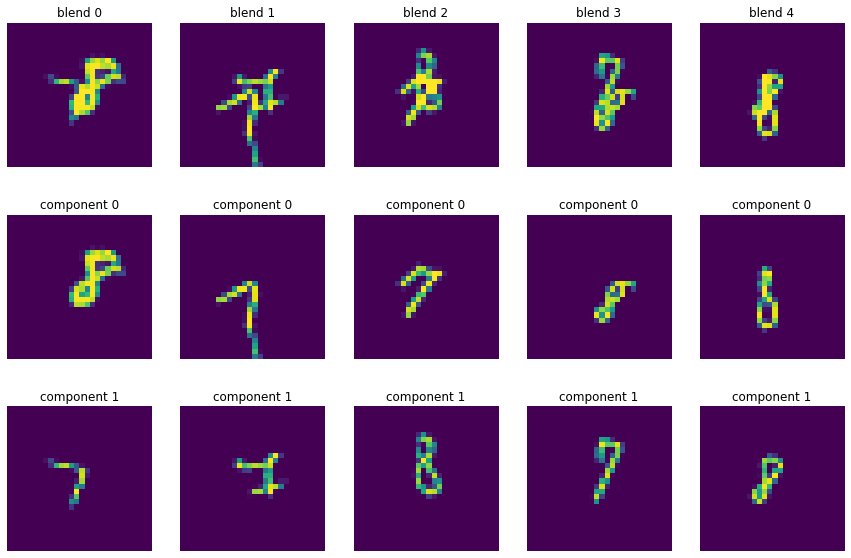

In [9]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [10]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [11]:
def decoder(x):
    #x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [12]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [13]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [35]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
______________________________________________________________________________________

In [36]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_15 (Functional)   (None, 32)                219584    
_________________________________________________________________
functional_17 (Functional)   (None, 28, 28, 1)         159169    
Total params: 378,753
Trainable params: 378,753
Non-trainable params: 0
_________________________________________________________________


In [37]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

beta=0.1
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [38]:
history=vae.fit(train_img,verbose=1,epochs=5,batch_size=batch_size)

Epoch 1/5
122/122 [==============================] - 6s 51ms/step - loss: 11.1098 - mse_loss: 10.7162 - kl_loss: 0.3936
Epoch 2/5
122/122 [==============================] - 6s 49ms/step - loss: 6.6583 - mse_loss: 6.2725 - kl_loss: 0.3859 1s - loss:
Epoch 3/5
122/122 [==============================] - 6s 49ms/step - loss: 5.5196 - mse_loss: 5.1444 - kl_loss: 0.3752
Epoch 4/5
122/122 [==============================] - 6s 50ms/step - loss: 4.8983 - mse_loss: 4.5287 - kl_loss: 0.3696
Epoch 5/5
122/122 [==============================] - 6s 48ms/step - loss: 4.4929 - mse_loss: 4.1285 - kl_loss: 0.3644


In [41]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(2, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
    return idx

[24 17 19 20 14]


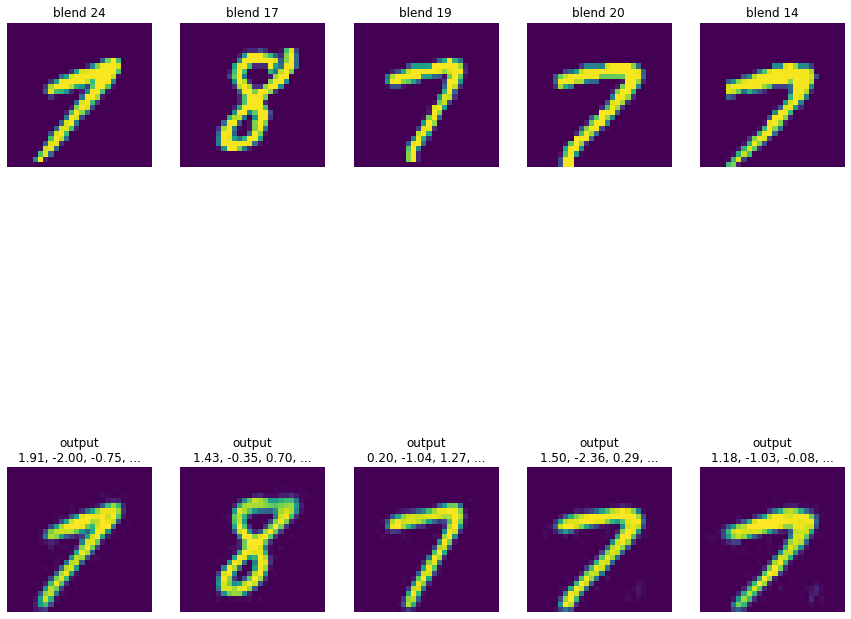

In [42]:
chosen=summary_plot(n,train_img,decode)

In [44]:
encode=Model(inputs,z)
encode.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False
    
decode.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
______________________________________________________________________________________

In [45]:
encoding=encode(inputs) #define the network
re=decode([encoding,input_compc])

vae=Model([inputs,input_compc],[re]) #adds methods of the network
vae.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_23 (Functional)      (None, 32)           219584      input_1[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_17 (Functional)      (None, 28, 28, 1)    159169      functional_23[0][0]              
                                                                 input_6[0][0]        

In [46]:
mse_loss=tf.reduce_mean(mse(input_compc,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

beta=0.1
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [47]:
history=vae.fit(together,verbose=1,epochs=5,batch_size=batch_size)

Epoch 1/5
600/600 [==============================] - 23s 39ms/step - loss: 10.1464 - mse_loss: 9.8631 - kl_loss: 0.2833
Epoch 2/5
600/600 [==============================] - 24s 40ms/step - loss: 9.9175 - mse_loss: 9.6219 - kl_loss: 0.2956
Epoch 3/5
600/600 [==============================] - 23s 39ms/step - loss: 9.8635 - mse_loss: 9.5659 - kl_loss: 0.2976
Epoch 4/5
600/600 [==============================] - 23s 38ms/step - loss: 9.8211 - mse_loss: 9.5241 - kl_loss: 0.2970
Epoch 5/5
600/600 [==============================] - 23s 39ms/step - loss: 9.7877 - mse_loss: 9.4892 - kl_loss: 0.2985


In [48]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
    return idx

[15281 21435 44536 13518 47529]


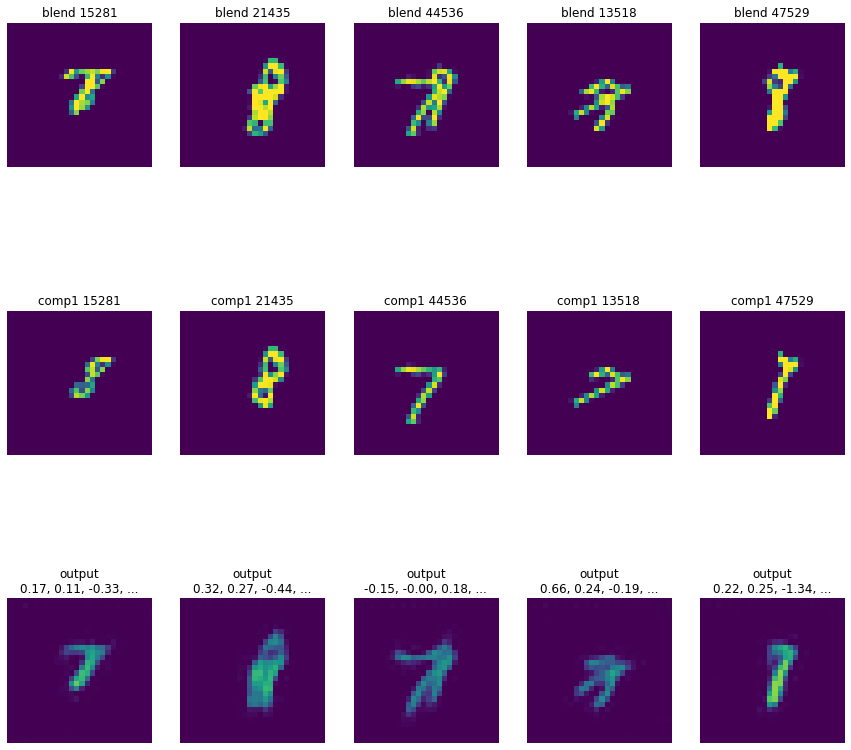

In [49]:
chosen=summary_plot(n,together,decode)

In [ ]:



    
#input blended image + central component (image always with galaxy at centre) (maybe with coord of peak)
#compute loss using central component